In [1]:
import pandas
import datetime
import numpy
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "count",\
                         "maxCntDst", "vel_bin" ]
velGmagDF.head()

,normMLT,MLAT,vSaps,azim,dst_bin,count,maxCntDst,vel_bin
0,-4.0,60.5,634.32,-10.10,"(-25, -10]",492,1355,"(600, 700]"
1,-4.0,60.5,609.64,-10.92,"(-25, -10]",492,1355,"(600, 700]"
2,-4.0,60.5,613.71,-12.20,"(-25, -10]",492,1355,"(600, 700]"
3,-4.0,60.5,778.50,-16.19,"(-25, -10]",492,1355,"(700, 800]"
4,-4.0,60.5,578.11,-15.40,"(-25, -10]",492,1355,"(500, 600]"


0.463858490746 0 948.31237284


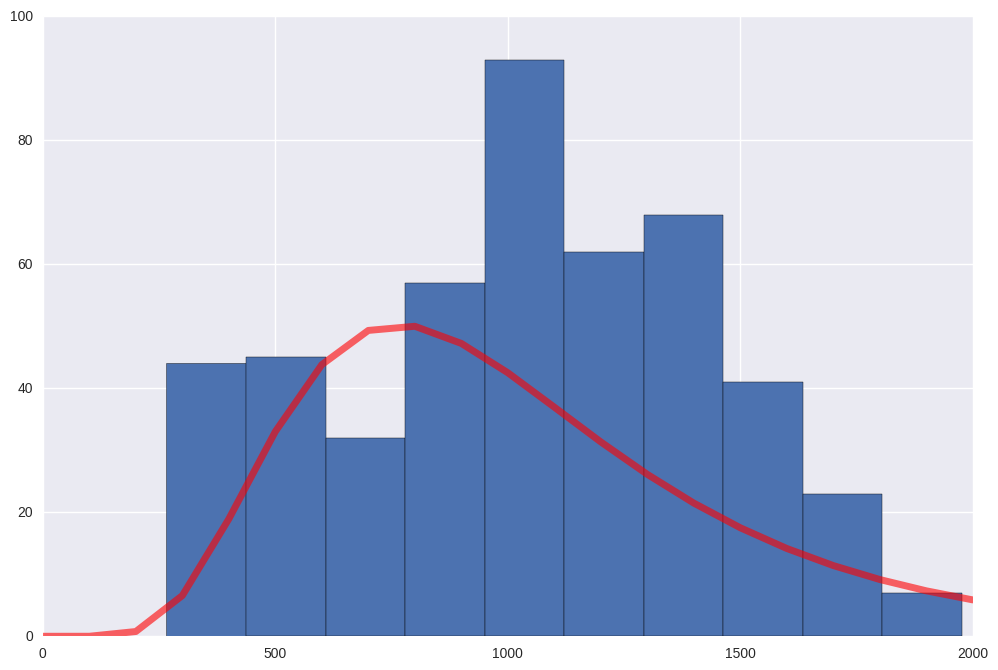

In [6]:
subDF = velGmagDF[ (velGmagDF["normMLT"] == -6.) & \
                  (velGmagDF["dst_bin"] == "(-150, -75]") & \
                  (velGmagDF["MLAT"] == 57.) ]
scatter,loc,mean = stats.lognorm.fit(subDF["vSaps"], floc=0)
print scatter, loc, mean
x_fit = numpy.arange(0.,2100.,100.)
pdf_fitted = stats.lognorm.pdf(x_fit,scatter,loc,mean)
fitVals = pdf_fitted/max(pdf_fitted) * 50.

f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
ax.plot(x_fit, fitVals, 'r-', lw=5, alpha=0.6, label='lognorm pdf')
subDF["vSaps"].hist(ax=ax)

-1.00698144963 1319.17871709 484.408291865


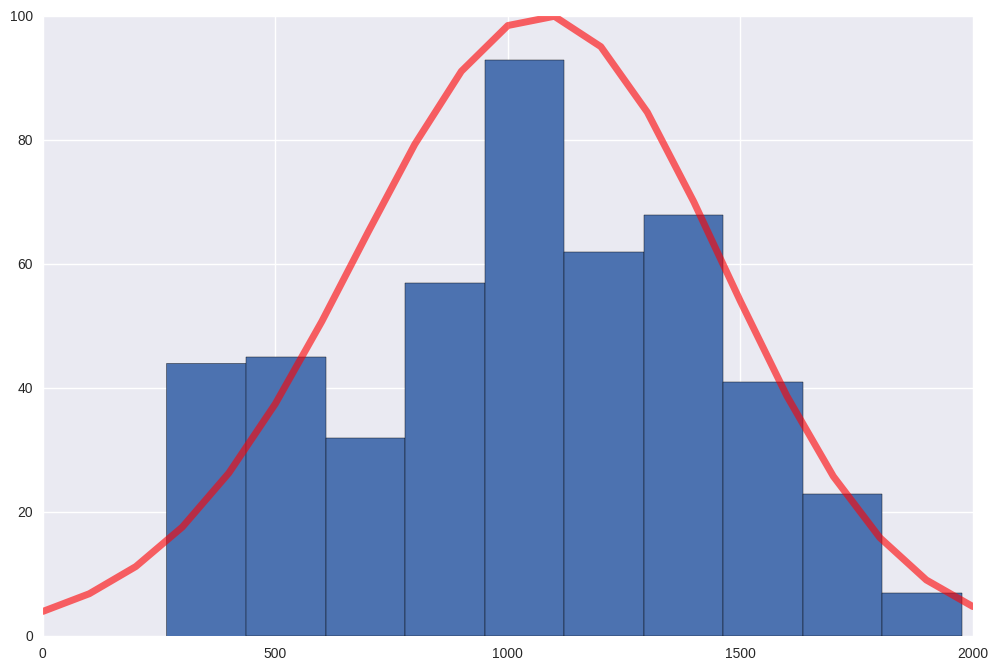

In [80]:
subDF = velGmagDF[ (velGmagDF["normMLT"] == -6.) & \
                  (velGmagDF["dst_bin"] == "(-150, -75]") & \
                  (velGmagDF["MLAT"] == 57.) ]

# subDF = velGmagDF[ (velGmagDF["normMLT"] == -3.) & \
#                   (velGmagDF["dst_bin"] == "(-50, -25]") & \
#                   (velGmagDF["MLAT"] == 61.) ]

scatter,loc,mean = stats.skewnorm.fit(subDF["vSaps"])
print scatter, loc, mean
x_fit = numpy.arange(0.,2100.,100.)
pdf_fitted = stats.skewnorm.pdf(x_fit,scatter,loc,mean)
fitVals = pdf_fitted/max(pdf_fitted) * 100.

f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
ax.plot(x_fit, fitVals, 'r-', lw=5, alpha=0.6, label='lognorm pdf')
subDF["vSaps"].hist(ax=ax)

In [ ]:
4.92750908335 337.718119303 367.754410933

In [77]:
aaa = stats.skewnorm.fit(subDF["vSaps"])
print aaa

(-1.0069814496319429, 1319.1787170878074, 484.40829186535746)
